<a href="https://colab.research.google.com/github/GrantCanty/BDT_STC/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting Started

##Import needed modules

In [ ]:
import duckdb
from google.colab import drive
import pandas as pd
import calendar
import gdown
import matplotlib.pyplot as plt
import seaborn as sns

#Create data warehouse

##Download files

In [ ]:
SHARED_FOLDER_ID = "13rT3mFZ2AKhQe3BOQkAxn8mnN3-kd3Yt"
gdown.download_folder(f'https://drive.google.com/drive/folders/{SHARED_FOLDER_ID}')
conn = duckdb.connect('/content/bdt_project/my_database.db')

Retrieving folder contents


Processing file 1OAr8CDu9FRQ62HRzCgvHcvit9Cfpz4Mx DSNY_Frequencies_20250210.csv
Processing file 1ov7qV3Pl1Qx9d4Gt9OGhh-NbQVBP_KMm DSNY_Garages_20250210.csv
Processing file 11ukDfIb00HSjdPnSbemci1n6FRsprZKzL0nZcyFfyRk DSNY_Monthly_Tonnage_Data
Processing file 1e_sRi1MpDGDQApu0641nGqHs0Nyfy-2j DSNY_Monthly_Tonnage_Data.csv
Processing file 1TZ46-LAHdmNyt_ct4XIas9Ab_NlT3GZL DSNY_Special_Waste_Drop-off_Sites_20250204.csv
Processing file 1cXXZSKWFNU2snujiczMLpifFkM5V8Ob_ Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY-Managed_Waste_20250210.csv
Processing file 1-47JasxsUfpjP6NDFrWzRugeXIq_JiZe my_database.db
Processing file 1-5pMsQii9m8v0gunEwGMUmhhzTayEp4C my_database.db.wal
Processing file 17kZ7i96GNCG-OkOdPf8FbiWX-I9Iooyp New_York_City_Population_by_Borough__1950_-_2040_20250204.csv
Processing file 1t9IYm5ekME8iiLPRpQWA8AJRejLlSvna New_York_City_Population_By_Community_Districts_20250204.csv
Processing file 10qZ_yoYFEmM4dh9CJNur8cnHAk-oC6K6SlVrMjx4Z50 NYC_Central_Park_weather_1869

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1OAr8CDu9FRQ62HRzCgvHcvit9Cfpz4Mx
To: /content/bdt_project/DSNY_Frequencies_20250210.csv
100%|██████████| 16.1M/16.1M [00:00<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ov7qV3Pl1Qx9d4Gt9OGhh-NbQVBP_KMm
To: /content/bdt_project/DSNY_Garages_20250210.csv
100%|██████████| 9.91k/9.91k [00:00<00:00, 18.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=11ukDfIb00HSjdPnSbemci1n6FRsprZKzL0nZcyFfyRk
From (redirected): https://docs.google.com/spreadsheets/d/11ukDfIb00HSjdPnSbemci1n6FRsprZKzL0nZcyFfyRk/export?format=xlsx
To: /content/bdt_project/DSNY_Monthly_Tonnage_Data
870kB [00:00, 9.43MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e_sRi1MpDGDQApu0641nGqHs0Nyfy-2j
To: /content/bdt_project/DSNY_Monthly_Tonnage_Data.csv
100%|██████████| 1.12M/1.12M [00:00<00:00, 96.5MB/s]
Downloading.

##Make tables

###Make Weather table

In [ ]:
table_name = "weather"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  date DATE,
  precipitation FLOAT,
  snow_fall FLOAT,
  snow_depth FLOAT,
  min_temp FLOAT,
  max_temp FLOAT,
);"""
)

In [ ]:
# clear table and load data
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM '/content/bdt_project/NYC_Central_Park_weather_1869-2022.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

###Make tonnage table
mgp tons is metal, glass, plastic


In [ ]:
table_name = "tonnage"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  date DATE,
  borough_name STRING,
  community_district STRING,
  refuse_tons DOUBLE,
  paper_tons DOUBLE,
  mgp_tons DOUBLE,
  res_organic_tons DOUBLE,
  school_organic_tons DOUBLE,
  leaves_tons DOUBLE,
  xmas_tree_tons DOUBLE,
  borough_id INTEGER
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/DSNY_Monthly_Tonnage_Data.csv')

transform.rename(columns={
    'MONTH': 'date',
    'BOROUGH': 'borough_name',
    'COMMUNITYDISTRICT': 'community_district',
    'REFUSETONSCOLLECTED': 'refuse_tons',
    'PAPERTONSCOLLECTED': 'paper_tons',
    'MGPTONSCOLLECTED': 'mgp_tons',
    'RESORGANICSTONS': 'res_organic_tons',
    'SCHOOLORGANICTONS': 'school_organic_tons',
    'LEAVESORGANICTONS': 'leaves_tons',
    'XMASTREETONS': 'xmas_tree_tons',
    'BOROUGH_ID': 'borough_id'
}, inplace=True)

transform['date'] = transform['date'].apply(lambda x: f"{x} / {calendar.monthrange(int(x[:4]), int(x[-2:]))[1]}")
transform['date'] = pd.to_datetime(transform['date'], format='%Y / %m / %d')

transform.to_csv('temp_tonnage_data.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_tonnage_data.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make recycling and diversion rates tables

In [ ]:
table_name = "recycling"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  zone STRING,
  district STRING,
  total_diversion_rate FLOAT,
  paper_capture_rate FLOAT,
  mgp_capture_rate FLOAT,
  total_caputre_rate FLOAT,
  date DATE
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Recycling_Diversion_and_Capture_Rates_20250204.csv')

transform.rename(columns={
    'Zone': 'zone',
    'District': 'district',
    'Fiscal Month Number': 'month',
    'Fiscal Year': 'year',
    'Month Name': 'month_name',
    'Diversion Rate-Total (Total Recycling / Total Waste)': 'total_diversion_rate',
    'Capture Rate-Paper (Total Paper / Max Paper)': 'paper_capture_rate',
    'Capture Rate-MGP (Total MGP / Max MGP)': 'mgp_capture_rate',
    'Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100': 'total_caputre_rate'
}, inplace=True)

transform['month'] = transform['month'].apply(lambda x: (x + 6) % 12)
transform['month'] = transform['month'].apply(lambda x: 12 if x == 0 else x)

transform['date'] = transform.apply(lambda x: f"{x['year']}-{x['month']}-{calendar.monthrange(x['year'], x['month'])[1] }", axis=1)
transform['date'] = pd.to_datetime(transform['date'], format='%Y-%m-%d')
transform.drop(columns=['month', 'month_name', 'year'], inplace=True)

transform.to_csv('temp_recycling_data.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_recycling_data.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make population table

In [ ]:
table_name = "population"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  Borough STRING,
  CD_Number INTEGER,
  CD_Name STRING,
  Population_1970 INTEGER,
  Population_1980 INTEGER,
  Population_1990 INTEGER,
  Population_2000 INTEGER,
  Population_2010 INTEGER,
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/New_York_City_Population_By_Community_Districts_20250204.csv')

transform.rename(columns={
    'Borough': 'Borough',
    'CD Number': 'CD_Number',
    'CD Namr': 'CD_Name',
    '1970 Population': 'Population_1970',
    '1980 Population': 'Population_1980',
    '1990 Population': 'Population_1990',
    '2000 Population': 'Population_2000',
    '2010 Population': 'Population_2010'
}, inplace=True)

transform.to_csv('temp_community_population.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_community_population.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Bins table

In [ ]:
table_name = "bins"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  dsny_zone STRING,
  dsny_district VARCHAR,
  site_type STRING,
  site_location VARCHAR,
  partner STRING,
  paper_bins INTEGER,
  mgp_bins INTEGER
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Public_Recycling_Bins_20250204.csv')

transform.rename(columns={
    'DSNY Zone': 'dsny_zone',
    'DSNY District': 'dsny_district',
    'Site type': 'site_type',
    'Site Location': 'site_location',
    'Partner': 'partner',
    'Paper Bins': 'paper_bins',
    'MGP Bins': 'mgp_bins'
}, inplace=True)

transform.to_csv('temp_public_recycling_bins.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_public_recycling_bins.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Garages Table

In [ ]:
table_name = "garages"
conn.execute(f"""
  CREATE TABLE IF NOT EXISTS {table_name} (
    address STRING,
    boro INTEGER,
    borocd INTEGER,
    city STRING,
    distrtict_code VARCHAR,
    name VARCHAR,
    object_id INTEGER,
    state STRING,
    zip INTEGER,
    longitude FLOAT,
    latitude FLOAT
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/DSNY_Garages_20250210.csv')

#transform.new_column = transform.apply(lambda row: f"POINT({row['longitude']} {row['latitude']})", axis=1)
transform.loc[transform['point'] != ' ', 'longitude'] = ' '
transform.loc[transform['point'] != ' ', 'latitude'] = ' '

def add_lat_and_long(row):
  #print(row['point'][7:-1].split(' '))
  row['longitude'] = row['point'][7:-1].split(' ')[0]
  row['latitude'] = row['point'][7:-1].split(' ')[1]
  #print(long, lat)
  return row

transform = transform.apply(add_lat_and_long, axis=1)

,ADDRESS,BBL,BIN,BORO,BOROCD,CITY,DISTRICTCODE,NAME,OBJECTID,STATE,TYPE,ZIP,longitude,latitude
0,130-23 150 Ave,4.118840e+09,4257531.0,4,410,South Ozone Park,QE10,QE12G,35,NY,Garage,11420,-73.8115260451189,40.6654363648992
1,800 E 176 St,2.029530e+09,2097278.0,2,206,Bronx,BX06,BX08G,293,NY,Garage,10460,-73.8894943216358,40.8418813521746
2,2495 2nd Avenue,1.017920e+09,1087849.0,1,111,New York,MN11,MN11G,250,NY,Garage,10035,-73.9329849481077,40.8045464078156
3,75-05 Douglaston Pkwy,NaN,4557769.0,4,411,Little Neck,QE11,QE11G,228,NY,Garage,11362,-73.733544363266,40.743658272532
4,75-05 Douglaston Pkwy,NaN,4557769.0,4,411,Little Neck,QE11,QE13A,77,NY,Garage,11362,-73.7348877593366,40.7429331157879


In [ ]:
transform.drop(columns=['BBL', 'BIN', 'TYPE', 'point'], inplace=True)

transform.rename(columns={
    'ADDRESS': 'address',
    'BORO': 'boro',
    'BOROCD': 'borocd',
    'CITY': 'city',
    'DISTRICTCODE': 'distrtict_code',
    'NAME': 'name',
    'OBJECTID': 'object_id',
    'STATE': 'state',
    'ZIP': 'zip',
}, inplace=True)

transform.to_csv('temp_public_garages.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_public_garages.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Frequencies table?
how often different routes happen

###Make Location of Dispoal Facilities Tables

In [ ]:
table_name = 'disposal_facilities'

conn.execute(f"""
  CREATE TABLE IF NOT EXISTS {table_name} (
    name VARCHAR,
    unique_id INTEGER,
    type STRING,
    address STRING,
    borough STRING,
    state STRING,
    zip INTEGER,
    latitude FLOAT,
    longitude FLOAT
);""")

In [ ]:
transform = pd.read_csv('/content/bdt_project/Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY-Managed_Waste_20250210.csv')
transform.drop(columns=['Point'], inplace=True)

transform.rename(columns={
    'Name': 'address',
    'Unique ID': 'boro',
    'Type': 'borocd',
    'Street Address': 'city',
    'Borough/City': 'distrtict_code',
    'State': 'name',
    'Zipcod': 'object_id',
    'Latitude': 'state',
    'Longitude': 'zip',
}, inplace=True)


transform.to_csv('temp_disposal_facilities.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_disposal_facilities.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

##Data Validation
write a function that checks each column to see if there are missing values

📌 Table Name: bins
   dsny_zone_nulls  dsny_district_nulls  site_type_nulls  site_location_nulls  \
0              0.0                  0.0              0.0                  0.0   

   partner_nulls  paper_bins_nulls  mgp_bins_nulls  
0            0.0               0.0             0.0  
🔹 Plotting distribution for column: paper_bins


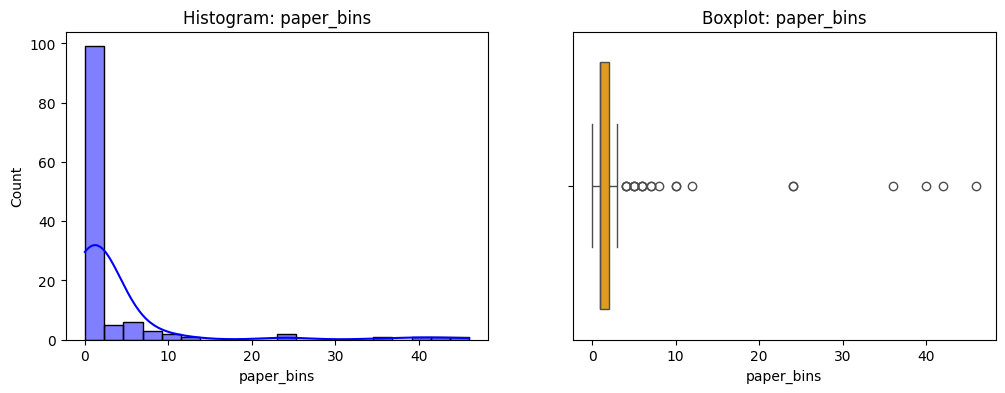

🔹 Plotting distribution for column: mgp_bins


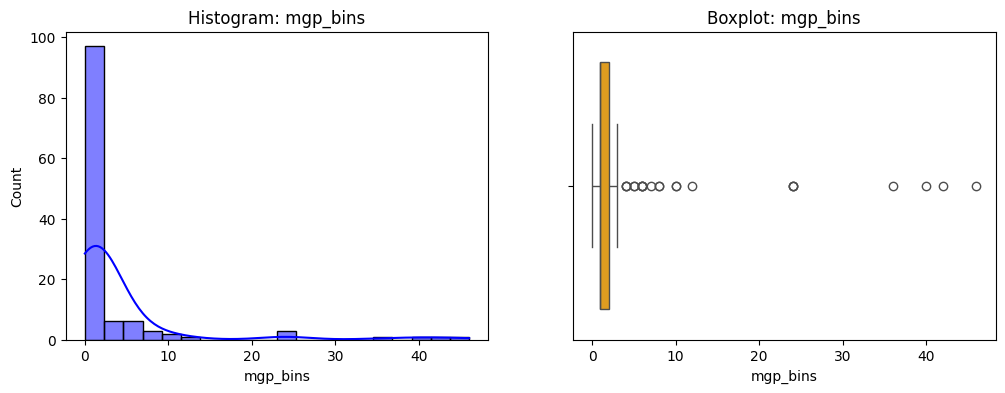

📌 Table Name: disposal_facilities
   name_nulls  unique_id_nulls  type_nulls  address_nulls  borough_nulls  \
0         0.0              0.0         0.0            0.0            0.0   

   state_nulls  zip_nulls  latitude_nulls  longitude_nulls  
0          0.0        0.0             0.0              0.0  
🔹 Plotting distribution for column: unique_id


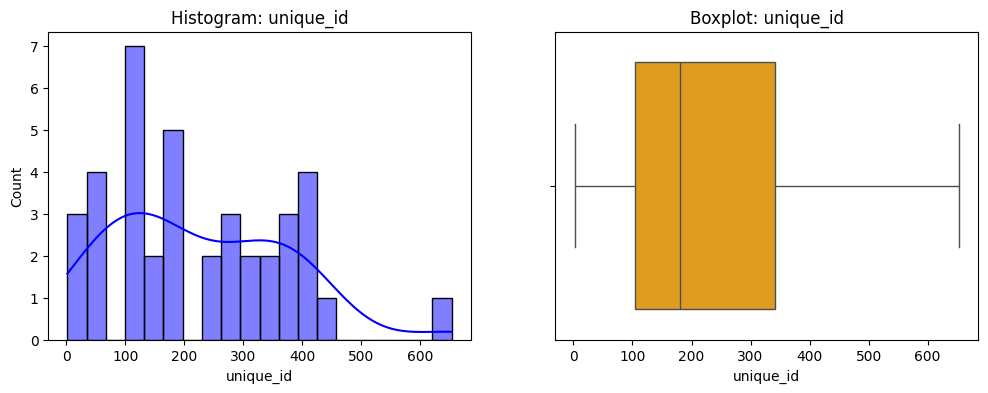

🔹 Plotting distribution for column: zip


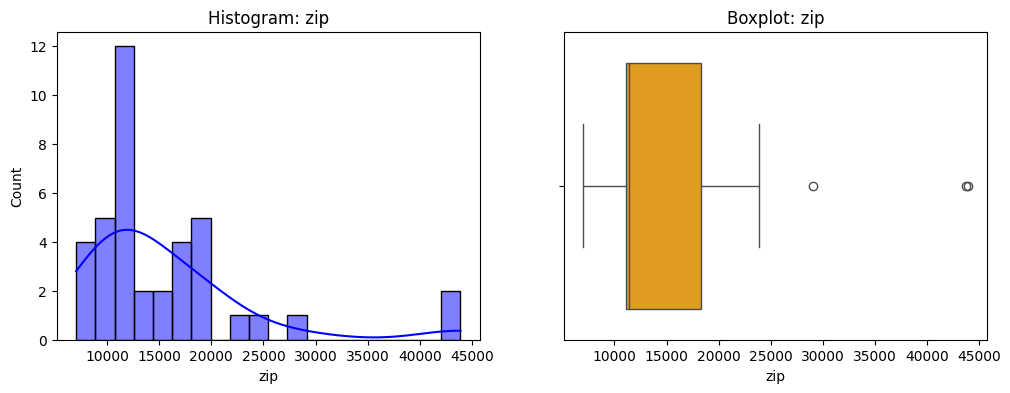

🔹 Plotting distribution for column: latitude


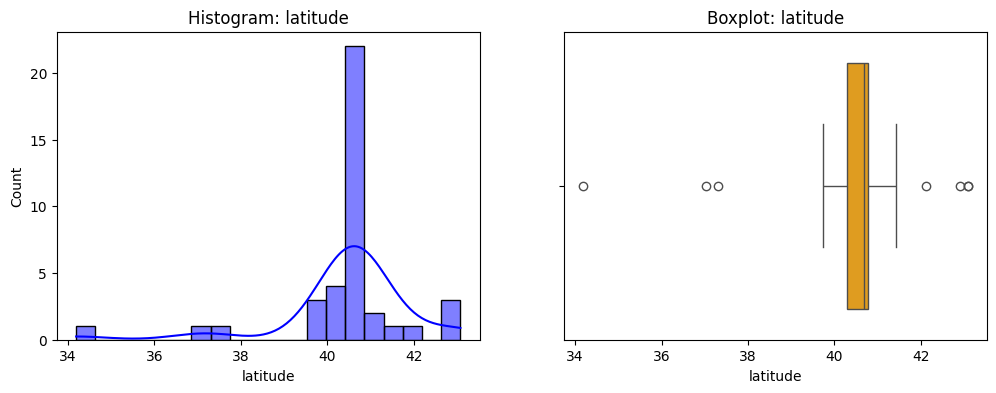

🔹 Plotting distribution for column: longitude


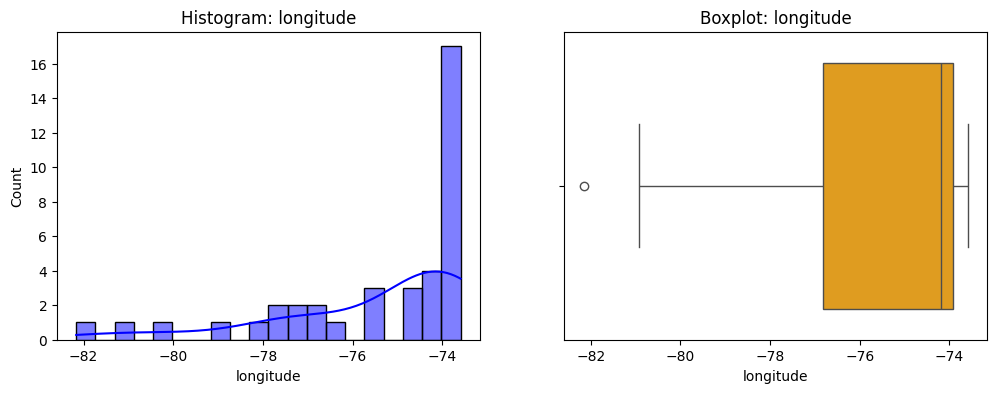

📌 Table Name: garages
   address_nulls  boro_nulls  borocd_nulls  city_nulls  distrtict_code_nulls  \
0            0.0         0.0           0.0         0.0                   0.0   

   name_nulls  object_id_nulls  state_nulls  zip_nulls  longitude_nulls  \
0         0.0              0.0          0.0        0.0              0.0   

   latitude_nulls  
0             0.0  
🔹 Plotting distribution for column: boro


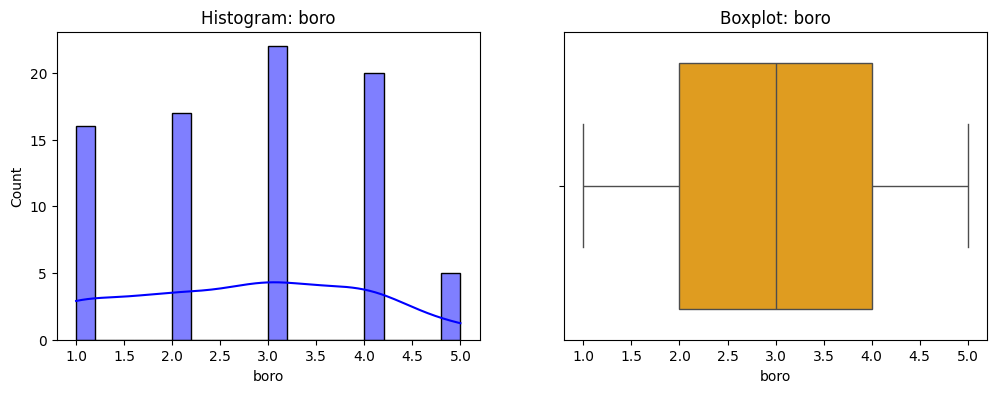

🔹 Plotting distribution for column: borocd


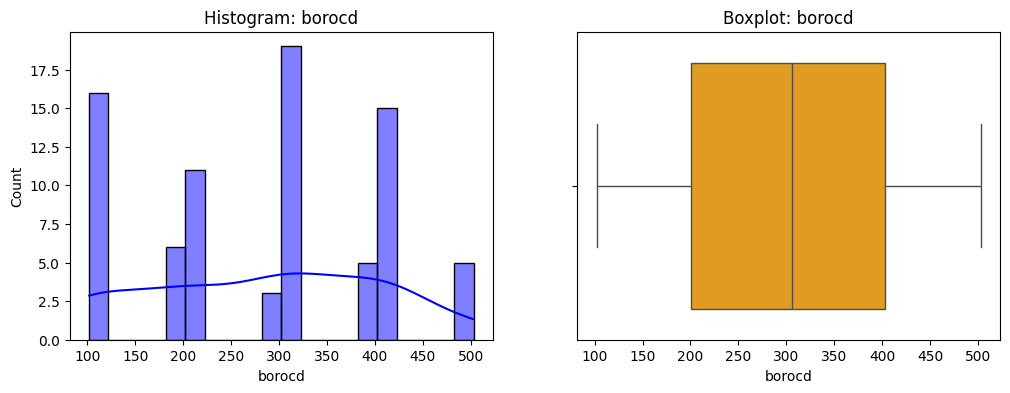

🔹 Plotting distribution for column: object_id


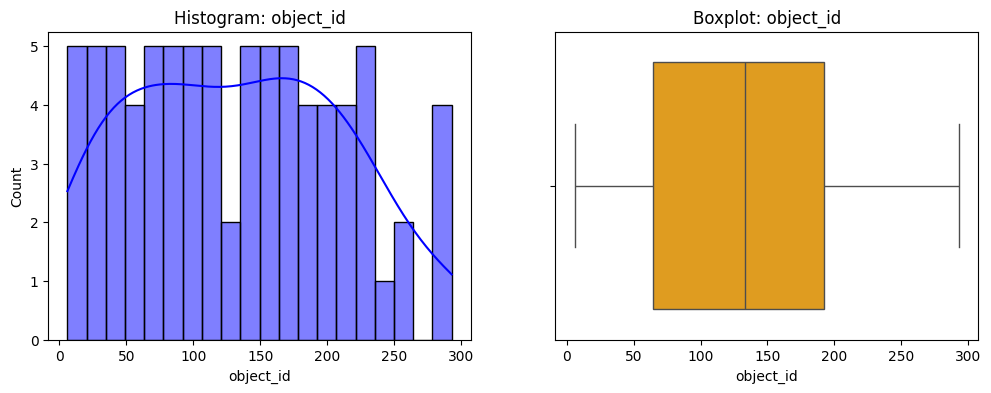

🔹 Plotting distribution for column: zip


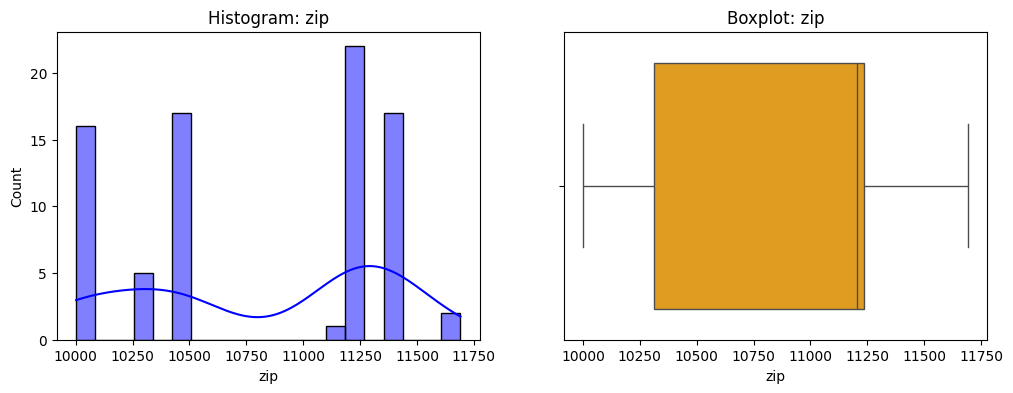

🔹 Plotting distribution for column: longitude


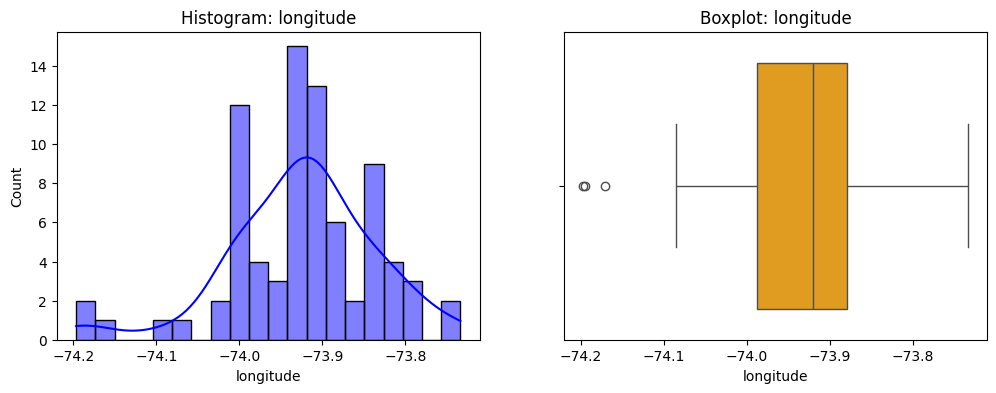

🔹 Plotting distribution for column: latitude


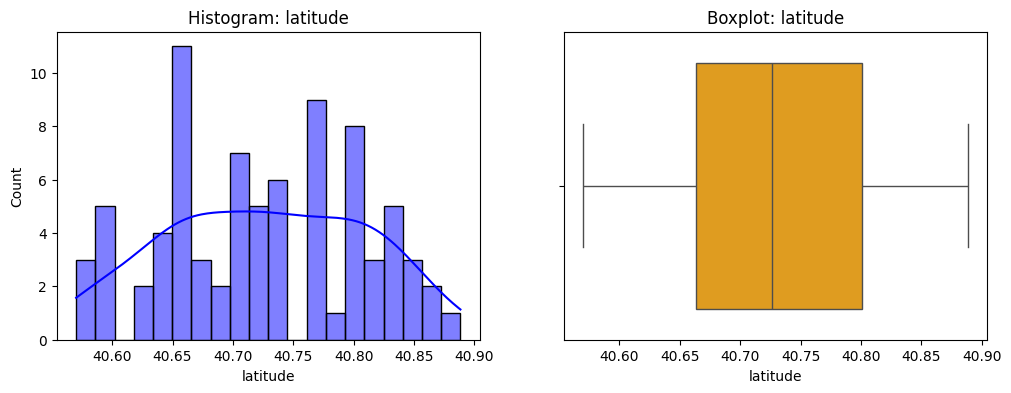

📌 Table Name: population
   Borough_nulls  CD_Number_nulls  CD_Name_nulls  Population_1970_nulls  \
0            0.0              0.0            0.0                    0.0   

   Population_1980_nulls  Population_1990_nulls  Population_2000_nulls  \
0                    0.0                    0.0                    0.0   

   Population_2010_nulls  
0                    0.0  
🔹 Plotting distribution for column: CD_Number


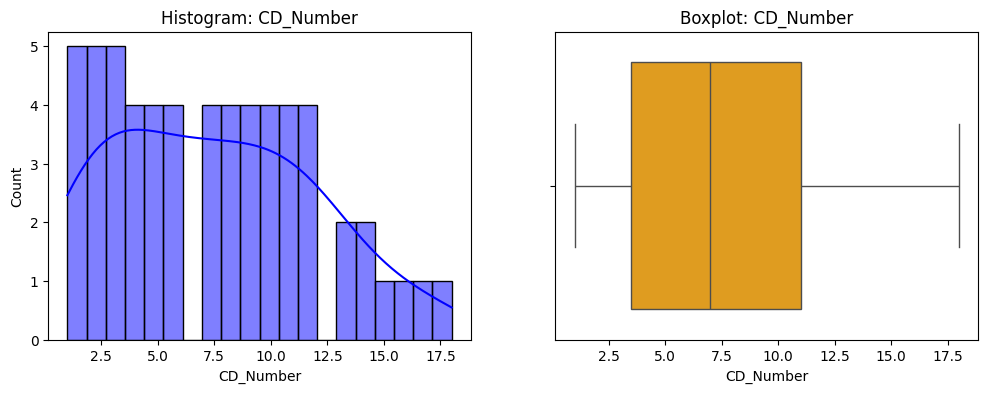

🔹 Plotting distribution for column: Population_1970


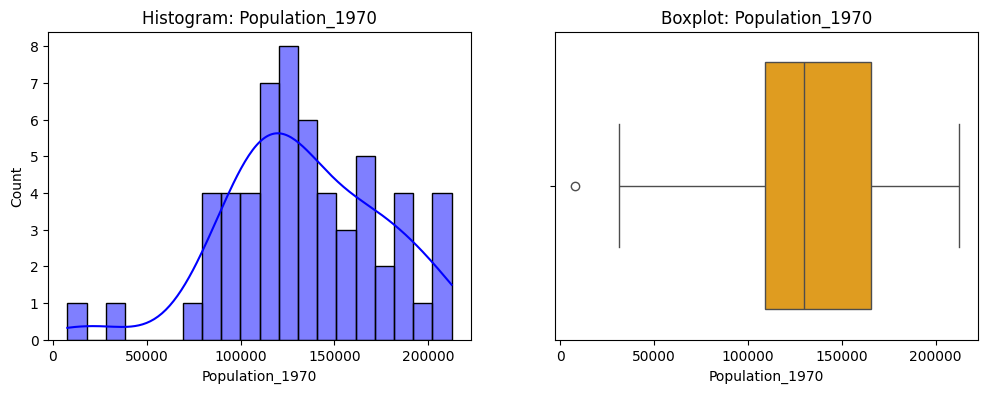

🔹 Plotting distribution for column: Population_1980


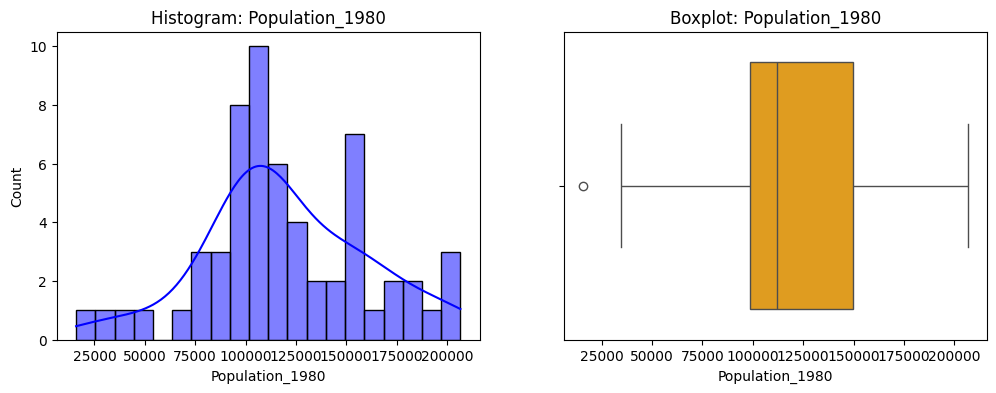

🔹 Plotting distribution for column: Population_1990


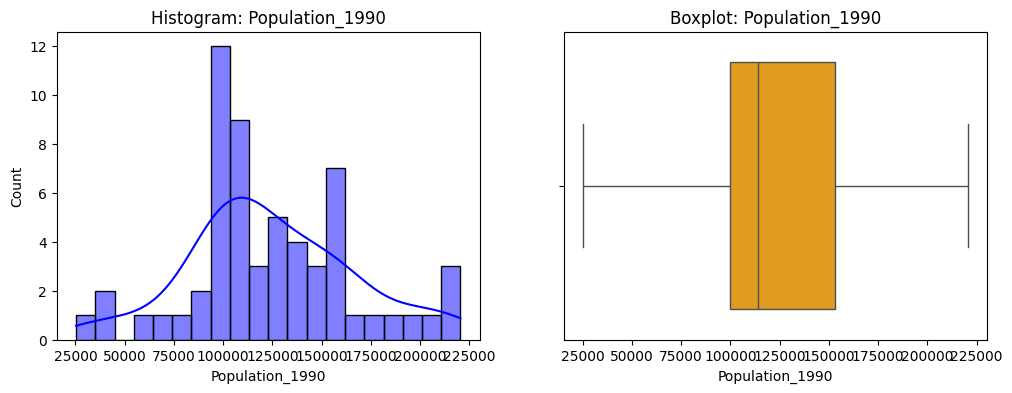

🔹 Plotting distribution for column: Population_2000


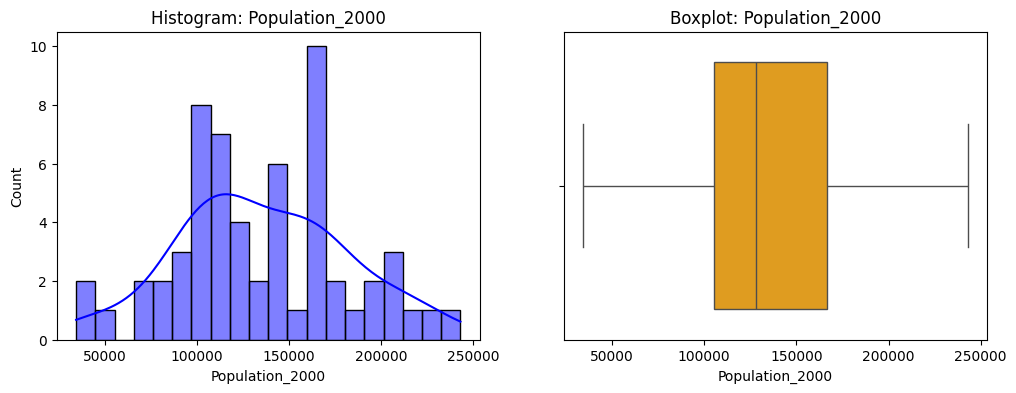

🔹 Plotting distribution for column: Population_2010


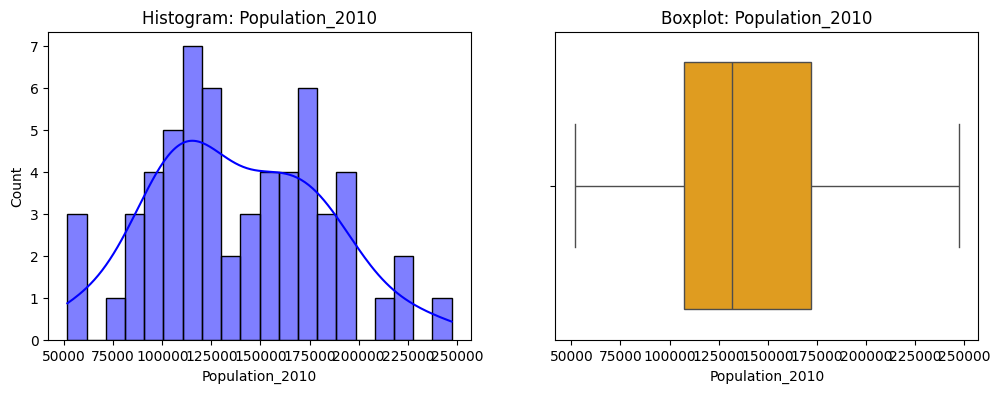

📌 Table Name: recycling
   zone_nulls  district_nulls  total_diversion_rate_nulls  \
0         0.0             0.0                         0.0   

   paper_capture_rate_nulls  mgp_capture_rate_nulls  total_caputre_rate_nulls  \
0                       0.0                     0.0                       0.0   

   date_nulls  
0         0.0  
🔹 Plotting distribution for column: total_diversion_rate


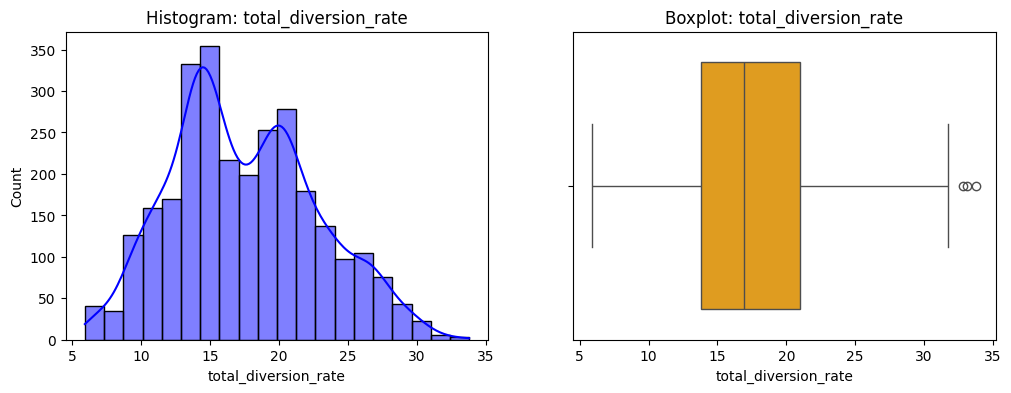

🔹 Plotting distribution for column: paper_capture_rate


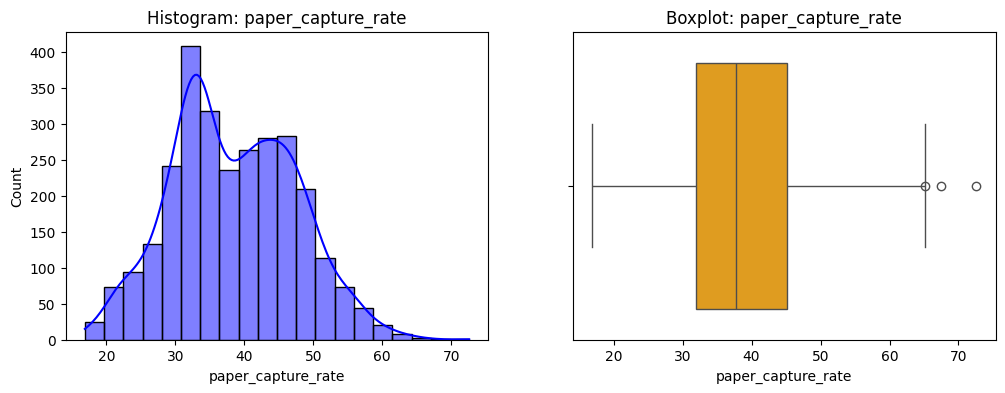

🔹 Plotting distribution for column: mgp_capture_rate


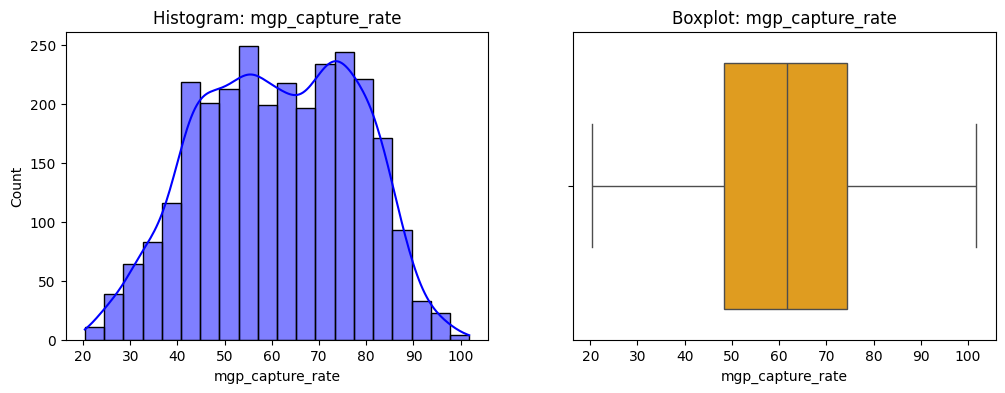

🔹 Plotting distribution for column: total_caputre_rate


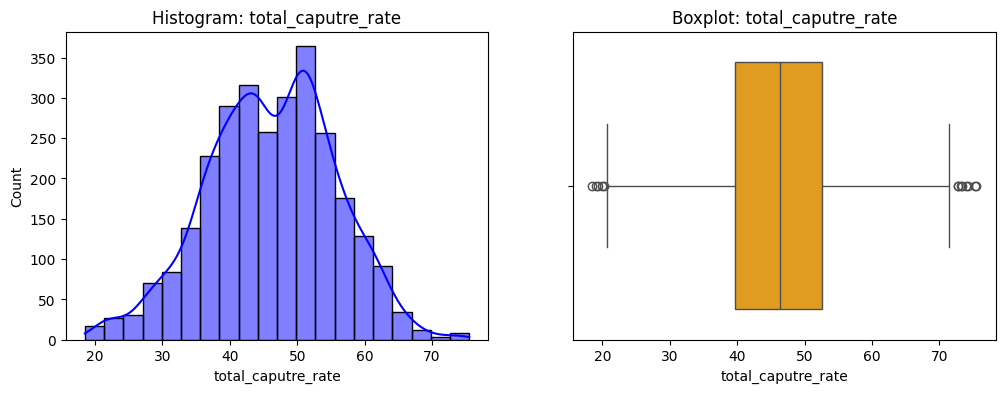

📌 Table Name: tonnage
   date_nulls  borough_name_nulls  community_district_nulls  \
0         0.0                 0.0                       0.0   

   refuse_tons_nulls  paper_tons_nulls  mgp_tons_nulls  \
0                0.0               0.0             0.0   

   res_organic_tons_nulls  school_organic_tons_nulls  leaves_tons_nulls  \
0                     0.0                        0.0                0.0   

   xmas_tree_tons_nulls  borough_id_nulls  
0                   0.0               0.0  
🔹 Plotting distribution for column: refuse_tons


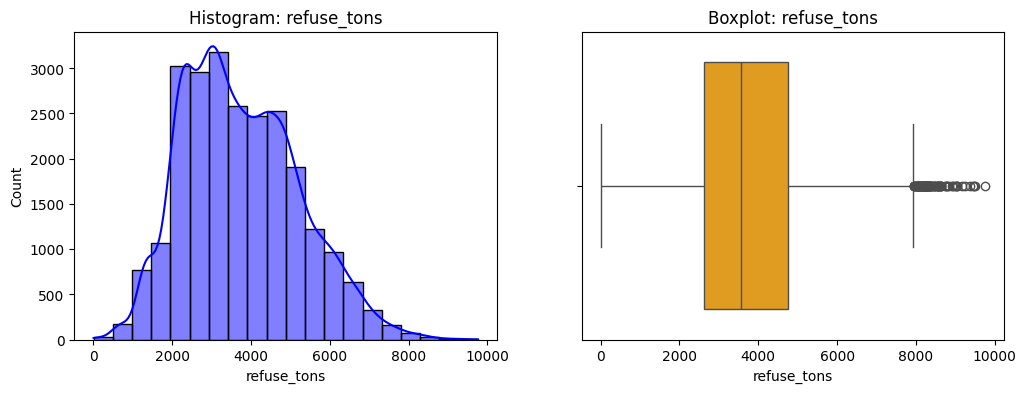

🔹 Plotting distribution for column: paper_tons


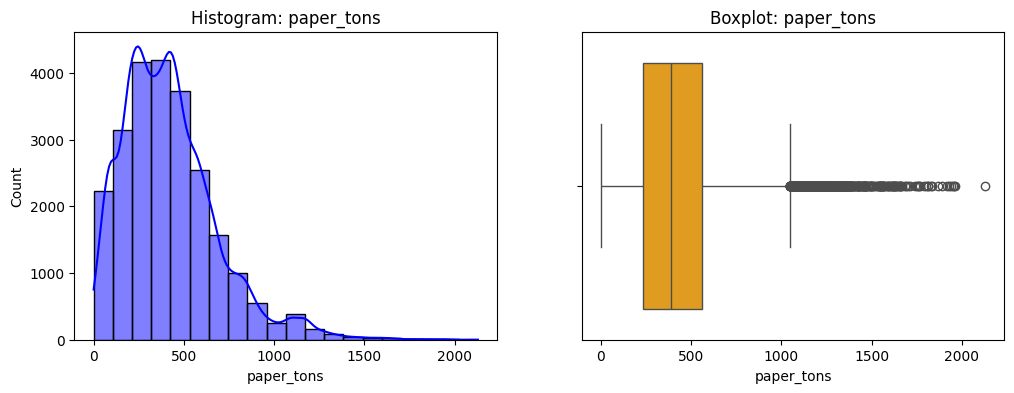

🔹 Plotting distribution for column: mgp_tons


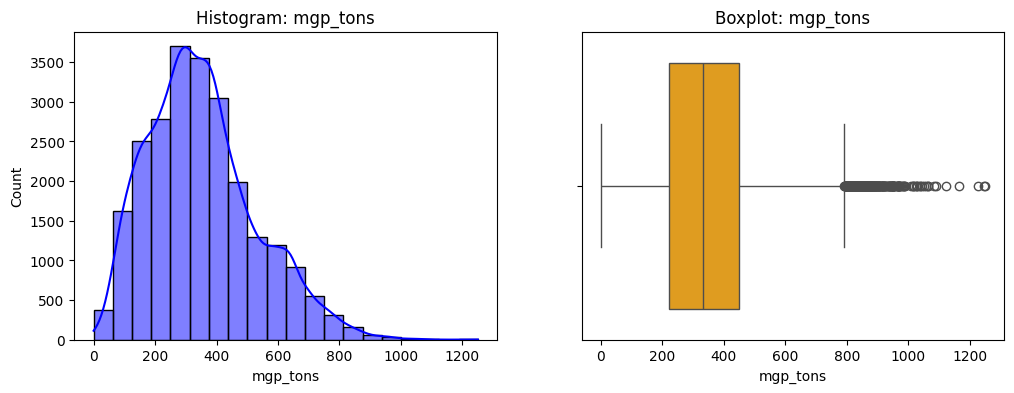

🔹 Plotting distribution for column: res_organic_tons


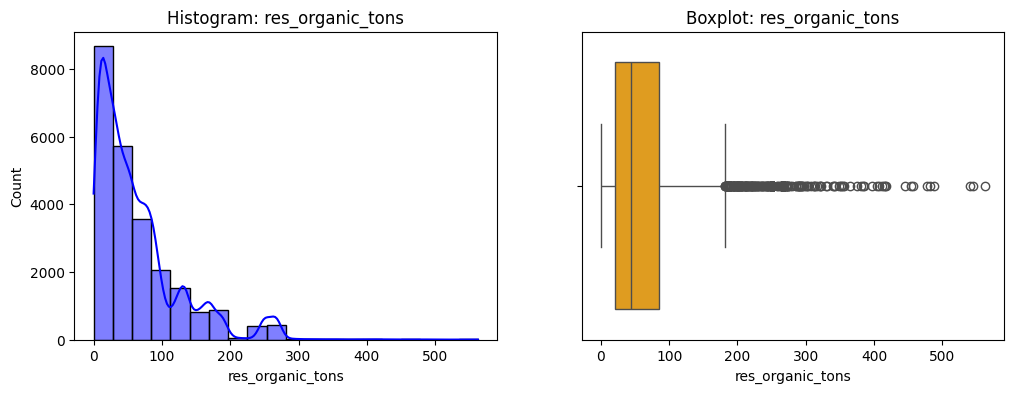

🔹 Plotting distribution for column: school_organic_tons


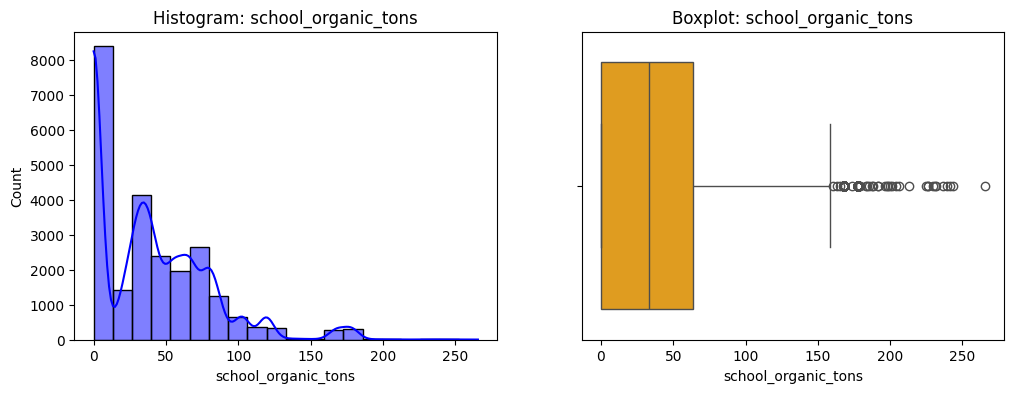

🔹 Plotting distribution for column: leaves_tons


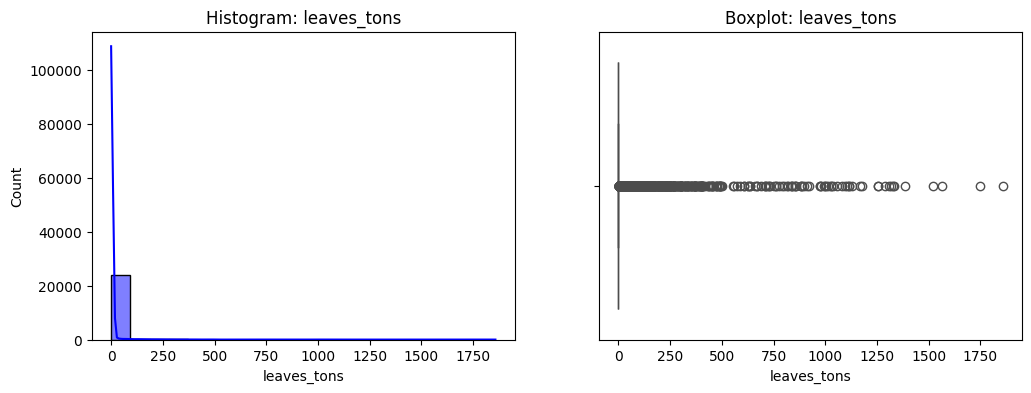

🔹 Plotting distribution for column: xmas_tree_tons


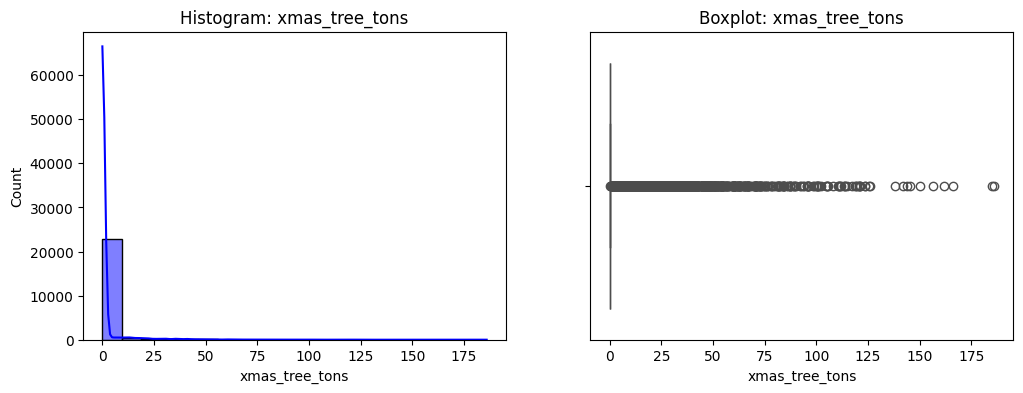

🔹 Plotting distribution for column: borough_id


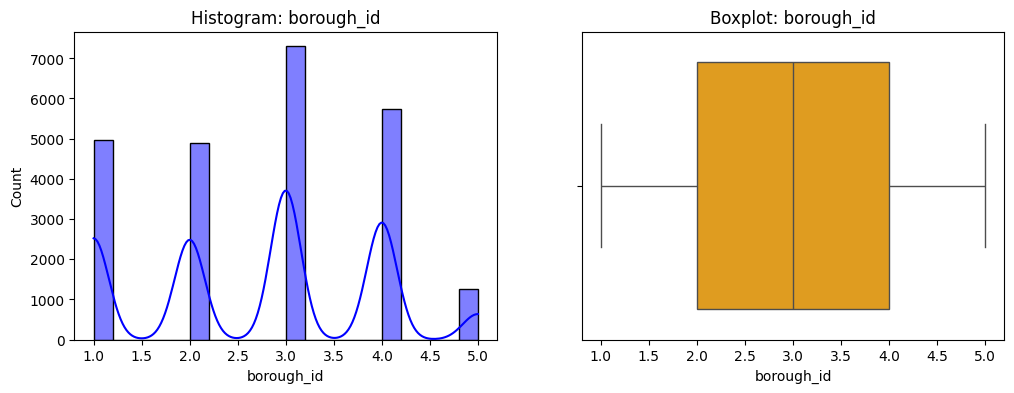

📌 Table Name: weather
   date_nulls  precipitation_nulls  snow_fall_nulls  snow_depth_nulls  \
0         0.0                  0.0              0.0               0.0   

   max_temp_nulls  min_temp_nulls  
0             0.0             0.0  
🔹 Plotting distribution for column: precipitation


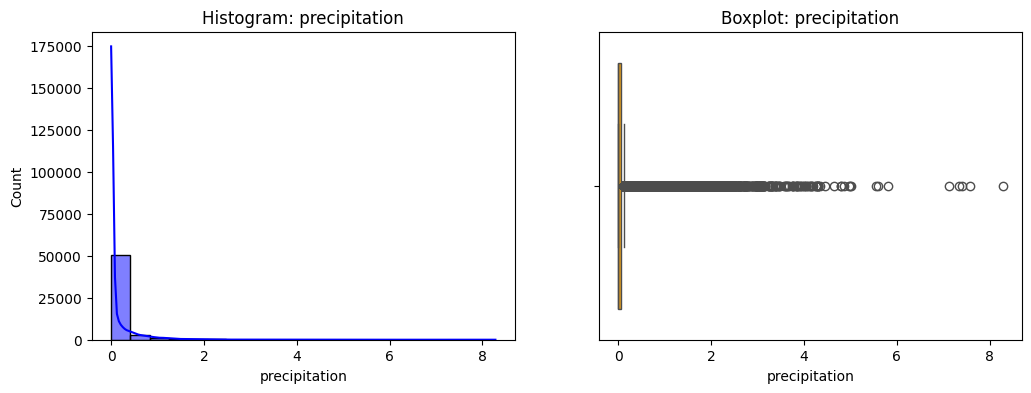

🔹 Plotting distribution for column: snow_fall


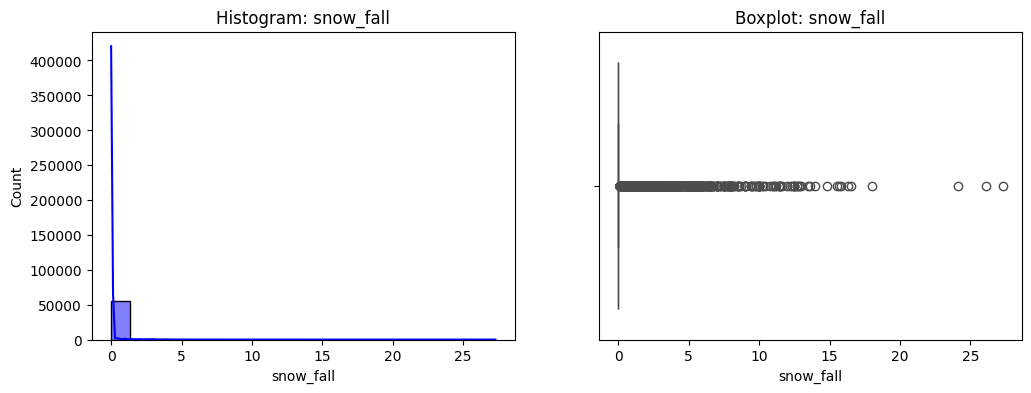

🔹 Plotting distribution for column: snow_depth


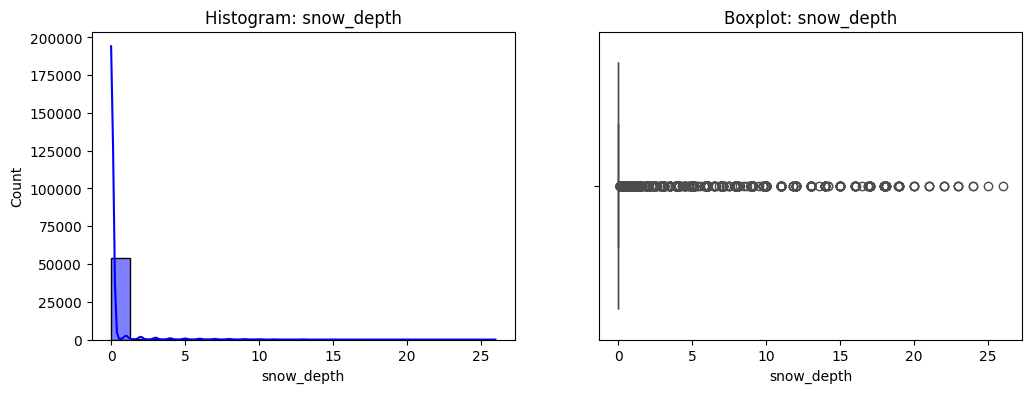

🔹 Plotting distribution for column: max_temp


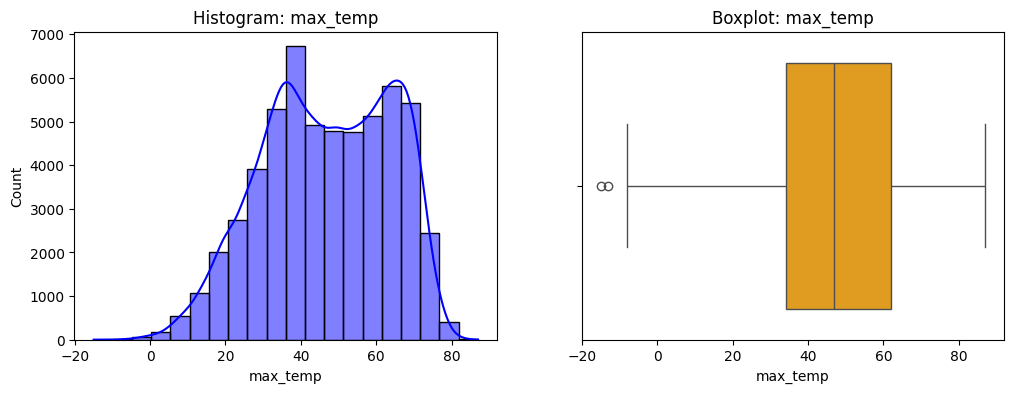

🔹 Plotting distribution for column: min_temp


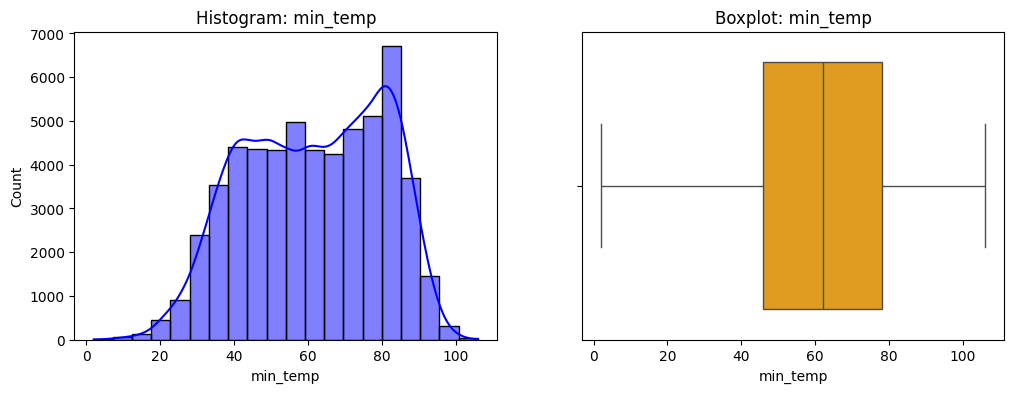

In [ ]:
tables = conn.execute("SHOW ALL;").fetchdf()['name']

# Loop through each table
for table_name in tables:
    print(f"📌 Table Name: {table_name}")

    # Get column names and types
    columns_info = conn.execute(f"PRAGMA table_info('{table_name}')").fetchall()
    columns = [col[1] for col in columns_info]  # Column names
    column_types = {col[1]: col[2] for col in columns_info}  # Column name -> Data type

    # Query to count NULL values
    null_query = "SELECT " + ", ".join([f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls" for col in columns]) + f" FROM {table_name}"
    missing_values = conn.execute(null_query).fetchdf()
    print(missing_values)

    # Fetch full table data
    df = conn.execute(f"SELECT * FROM {table_name}").fetchdf()

    # Loop through numeric columns and plot histograms & boxplots
    for col in columns:
        if column_types[col] in ('INTEGER', 'BIGINT', 'DOUBLE', 'FLOAT', 'DECIMAL'):  # Check if numeric
            print(f"🔹 Plotting distribution for column: {col}")

            # Create figure for plots
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram with KDE
            sns.histplot(df[col].dropna(), kde=True, ax=axes[0], bins=20, color='blue')
            axes[0].set_title(f"Histogram: {col}")

            # Boxplot
            sns.boxplot(x=df[col].dropna(), ax=axes[1], color='orange')
            axes[1].set_title(f"Boxplot: {col}")

            plt.show()

#Clean Data

##Clean Bins Data

In [ ]:
bins = conn.execute("SELECT * FROM bins").fetchdf()

bins = bins.dropna()

bins.to_csv('temp_bins.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE bins;")
conn.execute(f"COPY bins FROM 'temp_bins.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

##Clean Weather Data

###Snow Depth Projections
take yesterday's snow depth and add today's snowfall

In [ ]:
weather = conn.execute("SELECT * FROM weather").fetchdf()
weather['snow_fall'] = weather['snow_fall'].fillna(0)
weather['snow_depth_t-1'] = weather['snow_depth'].shift(1)
weather['snow_depth_t-1'] = weather['snow_depth_t-1'].fillna(0)

In [ ]:
weather['snow_depth'] = weather['snow_depth'].fillna(weather['snow_depth_t-1'] + weather['snow_fall'])
weather.drop(columns=['snow_depth_t-1'], inplace=True)

weather.head(16649)

,date,precipitation,snow_fall,snow_depth,max_temp,min_temp
0,1869-01-01,0.75,9.0,9.0,19.0,29.0
1,1869-01-02,0.03,0.0,0.0,21.0,27.0
2,1869-01-03,0.00,0.0,0.0,27.0,35.0
3,1869-01-04,0.18,0.0,0.0,34.0,37.0
4,1869-01-05,0.05,0.0,0.0,37.0,43.0
...,...,...,...,...,...,...
16644,1914-07-29,0.15,0.0,0.0,59.0,73.0
16645,1914-07-30,0.00,0.0,0.0,58.0,68.0
16646,1914-07-31,0.00,0.0,0.0,57.0,73.0
16647,1914-08-01,0.00,0.0,0.0,61.0,84.0


###Clean Max & Min Missing Temps

do average of future few years for max and min temp. we would look at the past but the missing data is from 1869, the first year when data started being collected. no way to look at past data in this case

In [ ]:
# Ensure that 'date' is in datetime format
weather['date'] = pd.to_datetime(weather['date'])

# Extract the year and month from the 'date' column
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month

# Function to fill missing values using data from the next 3 years for the same month
def fill_missing_with_future_years_mean(row, temp_column):
    # Get the year and month of the row with missing value
    year = row['year']
    month = row['month']

    # Filter data for the next 3 years (including the current row's year)
    future_years_data = weather[(weather['year'] >= year) & (weather['year'] <= year + 2) & (weather['month'] == month)]

    # Calculate the mean of the next 3 years for that month
    mean_value = future_years_data[temp_column].mean() if not future_years_data[temp_column].isnull().all() else None

    return mean_value

# Apply the function to fill missing values for 'max_temp' and 'min_temp'
for idx, row in weather[weather['max_temp'].isnull()].iterrows():
    weather.at[idx, 'max_temp'] = fill_missing_with_future_years_mean(row, 'max_temp')

for idx, row in weather[weather['min_temp'].isnull()].iterrows():
    weather.at[idx, 'min_temp'] = fill_missing_with_future_years_mean(row, 'min_temp')

# drop the 'year' and 'month' columns
weather = weather.drop(columns=['year', 'month'])


# Check the result
weather.head(124)

,date,precipitation,snow_fall,snow_depth,max_temp,min_temp
0,1869-01-01,0.75,9.0,9.0,19.000000,29.000000
1,1869-01-02,0.03,0.0,0.0,21.000000,27.000000
2,1869-01-03,0.00,0.0,0.0,27.000000,35.000000
3,1869-01-04,0.18,0.0,0.0,34.000000,37.000000
4,1869-01-05,0.05,0.0,0.0,37.000000,43.000000
...,...,...,...,...,...,...
119,1869-04-30,0.00,0.0,0.0,42.000000,55.000000
120,1869-05-01,0.58,0.0,0.0,42.000000,46.000000
121,1869-05-02,0.70,0.0,0.0,53.313953,68.058136
122,1869-05-03,0.02,0.0,0.0,53.313953,68.058136


make csv file and save csv to database

In [ ]:
weather.to_csv('temp_weather.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE weather;")
conn.execute(f"COPY weather FROM 'temp_weather.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

##Clean Tonnage Data

In [ ]:
tonnage = conn.execute("SELECT * FROM tonnage").fetchdf()

In [ ]:
tonnage['xmas_tree_tons'] = tonnage['xmas_tree_tons'].fillna(0)
tonnage['leaves_tons'] = tonnage['leaves_tons'].fillna(0)

add borough_id
Staten Island = 5, Queens = 4, Brooklyn = 3, Bronx = 2, Manhattan = 1

In [ ]:
tonnage['borough_id'] = tonnage['borough_name'].apply(lambda x: 1 if x == 'Manhattan' else (2 if x == 'Bronx' else (3 if x == 'Brooklyn' else (4 if x == 'Queens' else 5))))

finds rows where there is a missing value for refuse_tons and replaces null value with avg of its borough_id

In [ ]:
missing_vals = tonnage[tonnage['refuse_tons'].isnull()]

for idx, missing_val in missing_vals.iterrows():
    borough_id = missing_val['borough_id']
    community_district = missing_val['community_district']

    mean_refuse_tons = tonnage[tonnage['borough_id'] == 4]['refuse_tons'].mean()

    # Update the original tonnage DataFrame with the mean value for 'refuse_tons'
    tonnage.loc[idx, 'refuse_tons'] = mean_refuse_tons

replace missing school organic tons with 0 if between june and august. else, median of borough_id and community_district

In [ ]:
tonnage['month'] = tonnage['date'].dt.month

# Function to replace missing values based on conditions
def replace_missing_school_organic(row):
    if pd.isnull(row['school_organic_tons']):
        if row['month'] in [6, 7, 8]:  # June, July, August
            return 0
        else:
            # Get the median for the specific borough_id and community_district
            median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) &
                                   (tonnage['community_district'] == row['community_district'])]['school_organic_tons'].median()
            return median_value if pd.notnull(median_value) else 0
    return row['school_organic_tons']

# Apply the function row by row
tonnage['school_organic_tons'] = tonnage.apply(replace_missing_school_organic, axis=1)

In [ ]:
def replace_missing_res_organic(row):
  if pd.isnull(row['res_organic_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['res_organic_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['res_organic_tons']

tonnage['res_organic_tons'] = tonnage.apply(replace_missing_res_organic, axis=1)

In [ ]:
def replace_missing_paper(row):
  if pd.isnull(row['paper_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['paper_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['paper_tons']

tonnage['paper_tons'] = tonnage.apply(replace_missing_paper, axis=1)

In [ ]:
def replace_missing_mgp(row):
  if pd.isnull(row['mgp_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['mgp_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['mgp_tons']

tonnage['mgp_tons'] = tonnage.apply(replace_missing_mgp, axis=1)

In [ ]:
tonnage.drop(columns=['month'], inplace=True)

tonnage.to_csv('temp_tonnage.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE tonnage;")
conn.execute(f"COPY tonnage FROM 'temp_tonnage.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

#Data Modeling